In [55]:
# importa las librerias necesarias 
import pandas as pd
import numpy as np
import pyarrow as pa
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# lee el archivo parquet 
df_raw = pd.read_parquet("../data/reservas_hoteles.parquet")
df_raw.sample(5)

,id_reserva,id_cliente,nombre,apellido,mail,competencia,fecha_reserva,inicio_estancia,final_estancia,id_hotel,precio_noche,nombre_hotel,estrellas,ciudad
297,37a24fa6-c0ae-413c-8e53-eda4bd7e701f,9d199c9a-6d9b-47d1-a953-21c611e719ad,Salvador,Arco,salvador.arco@example.com,False,2025-02-06,2025-03-01,2025-03-02,2,338.76,Hotel Sol y Luna,1.0,Madrid
6726,91bb944a-d244-4687-b9af-ff4a139aa262,306f198d-50b9-4409-a425-0e86a6fbedb9,Emelina,Quevedo,emelina.quevedo@example.com,False,2025-02-12,2025-03-01,2025-03-02,15,181.23,Hotel Luz de Madrid,4.0,Madrid
3406,2060ab57-88f1-4f81-88bd-b370bf64ce7f,7d2ea0c4-ec6f-4c87-916b-cbdf983668da,Hector,Blazquez,hector.blazquez@example.com,True,,2025-03-01,2025-03-02,135,NaN,,NaN,
5519,88584a36-1443-4539-9b97-1e90332d01c0,3df94728-787d-4441-82b6-a355295f4cc0,José Antonio,Torrecilla,josé antonio.torrecilla@example.com,True,,2025-03-01,2025-03-02,113,NaN,,NaN,
6936,2a403492-b912-4b33-845c-a9fc8a7aaaf7,b0416850-d1e6-4ac1-8842-933561116e6f,Valerio,Saura,valerio.saura@example.com,False,2025-02-06,2025-03-01,2025-03-02,28,124.12,Hotel Maravilla Real,5.0,Madrid


In [3]:
# realiza una copia del archivo original
df = df_raw.copy()

In [4]:
# saca la forma del dataframe
df.shape

(15098, 14)

In [5]:
# crea una funcion que genera un reporte con informacion de nulos y tipo de dato de cada una de las columnas 
def info_reporte(dataframe):
    df_report = pd.DataFrame()
    df_report["Numero_nulos"] = dataframe.isnull().sum()
    df_report["Porcentaje_nulos"] = round((dataframe.isnull().sum()/dataframe.shape[0]*100), 2)
    df_report["Tipo_dato"] = dataframe.dtypes
    return df_report

In [6]:
# llama a la funcion aplicandola al dataframe 
info_reporte(df)

,Numero_nulos,Porcentaje_nulos,Tipo_dato
id_reserva,0,0.00,object
id_cliente,0,0.00,object
nombre,0,0.00,object
apellido,0,0.00,object
mail,0,0.00,object
competencia,0,0.00,bool
fecha_reserva,0,0.00,object
inicio_estancia,75,0.50,object
final_estancia,75,0.50,object
id_hotel,0,0.00,int64


- Tengo 15098 entradas y contamos con 14 columnas 

- En cuanto al tipo de dato de las columnas, ya se identifican determinadas columnas cuyo tipo de dato es incorrecto, concretamente las columnas de tipo datetime que están en tipo object. Es decir, fecha_reserva, inicio_estancia y final_estancia. 

- Nos faltaría la columna de id_ciudad que va a ser creada en la carga de los datos (en la carga de la tabla ciudad), al ser una columna con id seriados se genera automáticamente en ese momento. Por otro lado, nos falta la tabla entera de eventos con todas sus columnas (la vamos a obtener del escrapeo a través de la api).

- Observación primera de nulos: Contamos con nulos en 4 columnas (inicio_estancia, final_estancia, precio_noche, estrellas)

In [7]:
# convierte el tipo de dato de las 3 columnas de fecha en tipo datetime
col_fechas = ["fecha_reserva", "inicio_estancia", "final_estancia"]
for col in col_fechas:
    df[col] = pd.to_datetime(df[col])

In [8]:
# comprueba que se han cambiado correctamente los tipos de dato de las columnas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15098 entries, 0 to 15097
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id_reserva       15098 non-null  object        
 1   id_cliente       15098 non-null  object        
 2   nombre           15098 non-null  object        
 3   apellido         15098 non-null  object        
 4   mail             15098 non-null  object        
 5   competencia      15098 non-null  bool          
 6   fecha_reserva    9926 non-null   datetime64[ns]
 7   inicio_estancia  15023 non-null  datetime64[ns]
 8   final_estancia   15023 non-null  datetime64[ns]
 9   id_hotel         15098 non-null  int64         
 10  precio_noche     9874 non-null   float64       
 11  nombre_hotel     15098 non-null  object        
 12  estrellas        9926 non-null   float64       
 13  ciudad           15098 non-null  object        
dtypes: bool(1), datetime64[ns](3), float64

In [9]:
# saca el numero de duplicados por todas las columnas que hay en el dataframe
df.duplicated().sum()

np.int64(98)

In [10]:
# elimina los duplicados por todas las columnas del dataframe 
df.drop_duplicates(inplace=True)

In [11]:
# comprueba si hay duplicados por la columna id_reserva
df["id_reserva"].duplicated().sum()

np.int64(0)

In [12]:
# saca la forma del dataframe tras haber eliminado duplicados
df.shape

(15000, 14)

En cuanto a los duplicados, contamos con 98 duplicados por todas las columnas. Es decir, reservas que están completamente repetidas. En este caso, las eliminamos del conjunto de datos  nos quedamos con 15000 reservas. Además, una vez eliminadas estas reservas es importante observar si por el campo "id_reserva" hay algún duplicado, y ¿por qué? pues porque id_reserva es el identificador único de cada reserva (cada registro) y no puede estar repetido. Comprobamos que no hay duplicados por este campo y por lo tanto, todas las reservas son únicas y estaría todo correcto. Por el resto de id como el id_cliente o el id_hotel no hay que comprobarlo ya que por estos campos sí pueden haber duplicados. Pueden haber clientes que hayan realizado más de una reserva o hoteles que hayan sido reservados en más de una ocasión.

En cuanto a los valores nulos, de primeras parecía que únicamente habían 4 columnas con valores nulos (inicio_estancia, final_estancia, precio_noche, estrellas), pero por lo que he observado en estos primeros vistazos sobre el conjunto de datos, las columnas fecha_reserva, nombre_hotel y ciudad también tienen valores faltantes, lo que ocurre es que son espacios en blanco y no se están contando como valores nulos porque pandas no lo está identificando así. Además, parece que estos espacios en blanco van a tener que ver con los hoteles de la competencia, pues directamente son datos que aún hay están por recoger.

In [13]:
# reemplaza los valores en blanco por valores nulos 
col_blancos = ["fecha_reserva", "nombre_hotel", "ciudad"]
for col in col_blancos:
    df[col] = df[col].replace("", np.nan)

In [14]:
# llama a la funcion reporte aplicandola al dataframe 
info_reporte(df)

,Numero_nulos,Porcentaje_nulos,Tipo_dato
id_reserva,0,0.00,object
id_cliente,0,0.00,object
nombre,0,0.00,object
apellido,0,0.00,object
mail,0,0.00,object
competencia,0,0.00,bool
fecha_reserva,5172,34.48,datetime64[ns]
inicio_estancia,75,0.50,datetime64[ns]
final_estancia,75,0.50,datetime64[ns]
id_hotel,0,0.00,int64


In [15]:
# recuento de hoteles de competencia 
df[df["competencia"] == True].shape[0]

5172

In [16]:
# comprueba que los valores de las columnas fecha_reserva, nombre_hotel, estrellas y ciudad en hoteles de la competencia sean todos nulos
hoteles_competencia = df[df["competencia"] == True]
hoteles_competencia.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5172 entries, 0 to 14998
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id_reserva       5172 non-null   object        
 1   id_cliente       5172 non-null   object        
 2   nombre           5172 non-null   object        
 3   apellido         5172 non-null   object        
 4   mail             5172 non-null   object        
 5   competencia      5172 non-null   bool          
 6   fecha_reserva    0 non-null      datetime64[ns]
 7   inicio_estancia  5149 non-null   datetime64[ns]
 8   final_estancia   5149 non-null   datetime64[ns]
 9   id_hotel         5172 non-null   int64         
 10  precio_noche     0 non-null      float64       
 11  nombre_hotel     0 non-null      object        
 12  estrellas        0 non-null      float64       
 13  ciudad           0 non-null      object        
dtypes: bool(1), datetime64[ns](3), float64(2), i

Observamos como ahora ya si nos está sacando el recuento y el porcentaje de nulos de todas las columnas. De primeras ya es curioso que las columnas fecha_reserva, nombre_hotel, estrellas y ciudad tengan el mismo número de nulos, por lo de que parece que tienen relación con los hoteles de competencia. Y, efectivamente, coincide con el número de reservas que provienen de hoteles de la competencia (5172). Aún así, se ha comrpobado que los 5172 nulos de estas columnas correspondan con las 5172 reservas de hoteles de la competencia. Por lo tanto, algunas de ellas parecen que se van a sacar a través de web scraping, como la de nombre_hotel y la de estrellas. En el caso de la columna de ciudad no sería necesario web scraping, pues conocemos que los hoteles de la competencia también están ubicados en Madrid y, por lo tanto, podemos rellenar directamente con "Madrid".

In [17]:
# reemplaza los nulos de la columna ciudad por "Madrid"
df["ciudad"] = df["ciudad"].fillna("Madrid")

In [18]:
# saca el numero de valores unicos de las columnas inicio_estancia y final_estancia
df[["inicio_estancia", "final_estancia"]].nunique()

inicio_estancia    1
final_estancia     1
dtype: int64

Por otro lado, en cuanto a las columnas de inicio_estancia y final_estancia, del primer vistazo de los datos, también he podido observar que por lo que parece, ambas disponen de un único valor, y además, lo he comprobado, y es así. Es decir, para todas las reservas, la fecha de inicio de la estancia es la misma, concretamente el 1 de marzo de 2025, y para todas las reservas la fecha de fin de estancia también es la misma, concretamente el 2 de marzo de 2025, es decir, se están recogiendo datos de reservas exclusivas de una estancia de 1 día, concretamente entre el 1 y el 2 de marzo. En este caso, los valores nulos de ambas columnas, que encima suponen un porcentaje ínfimo en cada una de ellas (0,5%) también pueden ser rellenados con las mismas fechas.

In [19]:
# rellena los valores nulos de las columnas inicio_estancia y final_estancia por la unica fecha existente en cada columna
fechas_estancia = ["inicio_estancia", "final_estancia"]
for col in fechas_estancia:
    df[col] = df[col].fillna(df[col].dropna().unique()[0])

Por último, la última columna que tiene nulos es el precio_noche. Hay nulos en esta columna para 52 reservas de hoteles propios, y el resto de nulos corresponden a todos los hoteles de la competencia, es decir, un dato igualmente a scrapear con web scraping en el caso de los hoteles de la competencia  (asumiendo que el precio_noche es por persona). Para el caso de la fecha de reserva (que ya se ha visto que tiene los valores faltantes de los hoteles de la competencia), lo más lógico es rellenarla con el día en el que se hace el scraping del resto de columnas faltantes (nombre_hotel, estrellas, precio_noche) puesto que sobretodo el precio por noche de los hoteles va fluctuando bastante en función del día en el que cojas la reserva, asique por ello se da por hecho como si la reserva se hubiese hecho el día del scraping, que es realmente al día al que van a corresponder los precios. 

En el caso de los hoteles propios, hay que valorar como tratar estos 52 registros nulos en el precio de la noche.

In [20]:
# saca el numero de reservas correspondientes con hoteles propios y con precio_noche nulo
numero_reservas = df[(df["competencia"] == False) & (df["precio_noche"].isna())].shape[0]
print(numero_reservas)
numero_hoteles_competencia = df[df["precio_noche"].isna()].shape[0] - numero_reservas
print(numero_hoteles_competencia)

52
5172


In [21]:
# saca los hoteles y el numero de registros por cada hotel donde precio_noche es nulo
df_nulos_precio = df[(df["competencia"] == False) & (df["precio_noche"].isna())]
df_nulos_precio["nombre_hotel"].value_counts()

nombre_hotel
Hotel Sol y Luna          5
Hotel Torre Dorada        5
Hotel Camino del Sol      4
Hotel Mirador Real        4
Hotel Las Estrellas       4
Hotel Monte Verde         4
Hotel Puerta del Cielo    3
Hotel Encanto Real        3
Palacio del Sol           3
Gran Hotel Madrid         3
Hotel Brisas del Mar      2
Hotel Los Almendros       2
Hotel Vista Alegre        2
Hotel Rincón Sereno       2
Hotel Costa Azul          2
Hotel Luz de Madrid       1
Hotel Jardines del Rey    1
Hotel Palacio Imperial    1
Hotel Maravilla Real      1
Name: count, dtype: int64

Parece que todos los hoteles propios tienen al menos un valor nulo en la columna de precio_noche

In [22]:
# filtra por el hotel "Hotel Sol y Luna"
df[df["nombre_hotel"] == "Hotel Sol y Luna"].sample(5)

,id_reserva,id_cliente,nombre,apellido,mail,competencia,fecha_reserva,inicio_estancia,final_estancia,id_hotel,precio_noche,nombre_hotel,estrellas,ciudad
11096,40db05c6-2b22-4a7e-a16c-28a3958f152d,58dc7c2d-71fd-4ccd-ad02-f6f92782c9b2,Luisina,Bustamante,luisina.bustamante@example.com,False,2025-02-06,2025-03-01,2025-03-02,36,147.96,Hotel Sol y Luna,1.0,Madrid
3254,f8774920-d6aa-4aa7-b559-55ddb88aafd4,4184999d-5161-4f9e-abd2-e5c79718429d,María Dolores,Lozano,maría dolores.lozano@example.com,False,2025-02-03,2025-03-01,2025-03-02,6,219.05,Hotel Sol y Luna,2.0,Madrid
12847,36767889-c8d5-4296-a6d6-1c11487b7f77,16d7aaaa-a273-49ea-b713-1fe55589aaf5,Marisa,Guillén,marisa.guillén@example.com,False,2025-02-07,2025-03-01,2025-03-02,14,339.07,Hotel Sol y Luna,3.0,Madrid
6711,d12e9b8f-7c80-4e65-9566-7f66dad2bd3d,75b0c1a1-fa69-4d38-8042-3f771e6df389,Teófila,Pi,teófila.pi@example.com,False,2025-02-01,2025-03-01,2025-03-02,13,479.19,Hotel Sol y Luna,1.0,Madrid
8790,160273b6-5b24-4d74-9dca-e5facf77a07f,074779b9-cade-4cc5-89b4-4ea5c8257f5b,Odalis,Romero,odalis.romero@example.com,False,2025-02-04,2025-03-01,2025-03-02,33,285.30,Hotel Sol y Luna,1.0,Madrid


Como se puede observar, para por ejemplo el Hotel Sol y Luna el precio_noche es diferente para cada reserva, pues al final aunque la estancia vaya a ser el mismo día, los precios van fluctuando por momentos, y si por ejemplo reservas con más antelación, probablemente pues el precio por noche será menor. Lo que se puede valorar es sustituir los pocos nulos que hay por cada hotel por la media o la mediana (en función de los outliers) de la columna precio_noche para cada hotel. Antes de rellenar los nulos, habrá que hacer un análisis de outliers.

Por otro lado, al haber filtrado por este hotel concreto, estoy observando algo raro con los id y con las estrellas por hotel. Es decir, es raro que un mismo hotel (pues supongo que no existen en Madrid numerosos hoteles llamados "Hotel Sol y Luna") tenga asociados varios id_hotel diferentes y además, que tenga asociadas también distintas estrellas. Antes de continuar, lo primero que voy a hacer es observar si hay problemas con la asociación de los id, tanto el id_cliente como el id_hotel. 

En un principio asumo que lo que identifica de forma única a los hoteles es el nombre del hotel y que lo que identifica de forma única a los clientes es la combinación de su nombre + apellido o el correo electrónico directamente pues esta compuesto de ambas partes.

In [23]:
# compara el numero de valores unicos de los id_hotel con los nombres de hotel 
n_unicos_id_hotel = df["id_hotel"].nunique()
print(n_unicos_id_hotel)
n_unicos_nombre_hotel = df["nombre_hotel"].nunique()
print(n_unicos_nombre_hotel)

29
19


Hasta aquí tiene sentido pues disponemos de 29 id de hoteles (19 que corresponden a los 19 hoteles por su nombre único) y los restantes 10 que corresponden a los hoteles de la competencia.

Voy a observar si por ejemplo el id de hotel: 6, que veo que es uno de los que están asociados al Hotel Sol y Luna, está asociado a algún hotel más. 

In [24]:
# filtra por el hotel "Hotel Sol y Luna"
id_hotel_6 = df[df["id_hotel"] == 6]
id_hotel_6["nombre_hotel"].unique()

array(['Palacio del Sol', 'Hotel Rincón Sereno', 'Gran Hotel Madrid',
       'Hotel Monte Verde', 'Hotel Encanto Real', 'Hotel Las Estrellas',
       'Hotel Puerta del Cielo', 'Hotel Torre Dorada',
       'Hotel Los Almendros', 'Hotel Brisas del Mar',
       'Hotel Camino del Sol', 'Hotel Palacio Imperial',
       'Hotel Maravilla Real', 'Hotel Jardines del Rey',
       'Hotel Luz de Madrid', 'Hotel Mirador Real', 'Hotel Costa Azul',
       'Hotel Vista Alegre', 'Hotel Sol y Luna'], dtype=object)

Aquí sí encontramos un problema. Es decir, un mismo id, en este caso el 6, que en teoría debería identificar a un único hotel, está asociado a diversos hoteles. Es decir, claramente hay una errónea asociación en los id de hoteles. Esto hay que solucionarlo y lo que se va a hacer es que si se necesita trabajar en algún momento con el identificador único de cada hotel, se va a coger el nombre, y posteriormente en la carga de los datos, cuando ya dispongamos del nombre de todos los hoteles (propios y de la competencia), se genera automáticamente un id_hotel seriado que va a identificar a cada hotel por su nombre. 

Para el caso de las estrellas, lo que se observa es que un mismo hotel tiene asociadas distintas estrellas en función del cliente. Esto nos lleva a pensar que puede estar ocurriendo porque se esté recogiendo la valoración en estrellas individual de cada cliente en cada reserva. Lo que se va a hacer es, por cada hotel, calcular la media de las estrellas que tiene y de esta forma obtendremos la "valoración general" en estrellas para cada hotel (que es la valoración que vamos a obtener de los hoteles de la competencia). 

In [25]:
# asigna a la columnas de estrellas para cada nombre de hotel la media de sus estrellas 
df["estrellas"] = df["nombre_hotel"].map(df.groupby("nombre_hotel")["estrellas"].mean().round(1))

# filtra por el hotel "Hotel Sol y Luna" para comprobar que se ha hecho correctamente 
df[df["nombre_hotel"] == "Hotel Sol y Luna"].sample(5)

,id_reserva,id_cliente,nombre,apellido,mail,competencia,fecha_reserva,inicio_estancia,final_estancia,id_hotel,precio_noche,nombre_hotel,estrellas,ciudad
3370,fe543927-4359-4ced-96e3-72c120f982bb,c6e26b8a-7f36-4973-9920-1db2056cfbca,Feliciana,Pellicer,feliciana.pellicer@example.com,False,2025-02-09,2025-03-01,2025-03-02,36,411.59,Hotel Sol y Luna,3.0,Madrid
5865,ff10be22-9fad-4f51-a084-9d94a3e79acb,04cb9c24-7cb1-4ecb-9ec4-246a15632cb3,Bárbara,Pera,bárbara.pera@example.com,False,2025-02-01,2025-03-01,2025-03-02,28,479.45,Hotel Sol y Luna,3.0,Madrid
12618,f28faed0-1083-4211-9dbc-e8250a98ffbd,be6a05a0-6307-43ab-8bb8-172690e713a4,Margarita,Lerma,margarita.lerma@example.com,False,2025-02-06,2025-03-01,2025-03-02,3,491.70,Hotel Sol y Luna,3.0,Madrid
11000,0eac76c6-12f1-4d8c-9165-a2511c77ff77,d3515ebe-85c3-468c-a660-f79d2f8657b4,Macarena,Gracia,macarena.gracia@example.com,False,2025-02-08,2025-03-01,2025-03-02,15,213.27,Hotel Sol y Luna,3.0,Madrid
6131,dc3619ec-a45c-4500-ad2a-3f60f54e4694,b70d3b42-376c-4714-999a-cef1932d84c6,Rufina,Alegre,rufina.alegre@example.com,False,2025-02-12,2025-03-01,2025-03-02,43,389.08,Hotel Sol y Luna,3.0,Madrid


Por otro lado, se va a comprobar si el id_cliente identifica correctamente a cada uno de los clientes (por su nombre y apellido que es lo que en principio les hace únicos).

In [26]:
# saca el numero de valores unicos de correos de clientes y de id de clientes 
n_clientes_nombre = df["mail"].nunique()
n_id_clientes = df["id_cliente"].nunique()
print(n_clientes_nombre)
print(n_id_clientes)

14905
14847


En principio, el correo electrónico, compuesto por el nombre y apellido de cada uno de los clientes es lo que les identifica. Si esto es así, estaría habiendo un problema, pues parece que hay más clientes que id que les identifiquen, es decir, hay más de un cliente (con nombre y apellido distinto) con el mismo identificador. Vamos a observar en qué casos está ocurriendo esto. Lo suyo sería que si hay 14905 correos únicos, hubiera 14905 identificadores únicos. Es verdad que podría ocurrir que dos clientes diferentes compartiesen nombre y apellido pero no tenemos nada más exacto a la composición de nombre+apellido para identificar a los clientes, por lo tanto lo vamos a hacer por el correo electrónico.

In [27]:
# saca los id_cliente que estan asociados a mas de un email diferente 
df_duplicados = df.groupby("id_cliente")["mail"].nunique().reset_index()
df_duplicados[df_duplicados["mail"] > 1]

,id_cliente,mail
135,021189fb-20a8-41c9-9313-90980978ca9e,2
219,0356706f-5225-4ac8-ab63-1101fa34ca9c,2
377,05ad7abe-dc32-471c-afcc-a477676bae5a,2
627,0a1cc666-c58f-4d35-bca5-1ada0c2b1db5,2
806,0d8a80ff-e17c-46e9-ab87-31240edc2fb7,2
...,...,...
14497,f9c8c427-1258-40eb-8851-b13073c066c6,2
14533,fa6dca51-93f8-49ab-b968-64fad32964a7,2
14569,fb13250c-e420-444d-9cdb-4327fc1077f7,2
14608,fba96362-d117-4f45-b405-f735d813833a,2


In [28]:
# observa uno de los id_cliente duplicado
df[df["id_cliente"] == "021189fb-20a8-41c9-9313-90980978ca9e"]

,id_reserva,id_cliente,nombre,apellido,mail,competencia,fecha_reserva,inicio_estancia,final_estancia,id_hotel,precio_noche,nombre_hotel,estrellas,ciudad
1155,f34d876b-9c8e-4ca9-b140-439d74e46dff,021189fb-20a8-41c9-9313-90980978ca9e,Andrea,Requena,andrea.requena@example.com,False,2025-02-11,2025-03-01,2025-03-02,15,322.94,Hotel Puerta del Cielo,3.0,Madrid
2129,8228a207-4053-4bda-bfa5-2fa0cad1b54c,021189fb-20a8-41c9-9313-90980978ca9e,Jaime,Estevez,jaime.estevez@example.com,True,NaT,2025-03-01,2025-03-02,186,NaN,NaN,NaN,Madrid


Por ejemplo este id está asociado a por un lado a Andrea Requena y por otro lado a Jaime Estevez, cuando realmente son dos clientes distintos. Esto puede ocurrir porque imaginemos que la cuenta desde la que se hace la reserva la tiene Andrea Requena y en una ocasión ha reservado a su nombre para ella misma, pero en otra ocasión ha reservado para un amigo que sería Jaime Estevez. Al final, son dos clientes distintos pero coge el mismo id porque se tiene en cuenta la cuenta desde la que se ha reservado que sería la misma realmente, la de Andrea. Lo que ocurre es que a la hroa de hacer la carga a la base de datos, esto va a dar error porque clientes distintos comparten un mismo id. Lo que tenemos que hacer es solucionar esto para que cada cliente (identificado por su correo) disponga de su propio id. Vamos a generar un id aleatorio en formato texto que va a ir de 1 14905.

In [29]:
# saca los correos unicos de los clientes 
lista_correos_unicos = df["mail"].unique()
lista_correos_unicos

array(['feliciana.cantón@example.com', 'leonardo.hierro@example.com',
       'maite.calatayud@example.com', ..., 'nadia.verdugo@example.com',
       'custodia.marco@example.com', 'brígida.salom@example.com'],
      shape=(14905,), dtype=object)

In [30]:
# modifica la columna id_cliente generando un id_cliente que comienza en 1 y va asignando cada numero en formato texto a un mail aleatorio
dicc_id_clientes = {}
conteo = 1

for correo in lista_correos_unicos:
    dicc_id_clientes[correo] = conteo 
    conteo = conteo + 1

df["id_cliente"] = df["mail"].map(dicc_id_clientes).astype(str)

print(df["id_cliente"].nunique())
print(df["id_cliente"].dtypes)

df.sample(1)

14905
object


,id_reserva,id_cliente,nombre,apellido,mail,competencia,fecha_reserva,inicio_estancia,final_estancia,id_hotel,precio_noche,nombre_hotel,estrellas,ciudad
2603,98d94ec3-7e58-415b-a745-6f2321108d4b,2604,Heliodoro,Blasco,heliodoro.blasco@example.com,False,2025-02-05,2025-03-01,2025-03-02,35,240.22,Hotel Luz de Madrid,3.1,Madrid


In [31]:
# comprueba el id de los correos andrea.requena@example.com y jaime.estevez@example.com para confirmar que se ha generado correctamente 
print(df[df["mail"] == "andrea.requena@example.com"].iloc[:,1])
print(df[df["mail"] == "jaime.estevez@example.com"].iloc[:,1])

1155    1156
Name: id_cliente, dtype: object
2129    2130
Name: id_cliente, dtype: object


Parece que ya está correcto ya que los dos correos de clientes distintos que antes compartían el mismo id y ahora ya cada uno tiene su propio id que les identifica por separado de forma única.

Como bien ya se había dicho, los nulos en la columna de precio_noche para los hoteles propios se van a rellenar a través de la media / mediana de los precios que tengamos registrados para cada hotel de forma separada. Se va a hacer por cada hotel por separado porque los precios de cada hotel son diferentes (hay hoteles mucho más caros que otros) y no tendría sentido hacer una media o mediana de todos los precios para todos los hoteles ya que quizás el precio de un hotel caro es un outlier para los precios generales que tiene un hotel más barato. Es más coherente hacerlo por separado y por lo tanto antes de nada para decidir si rellenar los nulos con la media o la mediana, habrá que hacer un análisis de outliers para cada hotel.

In [32]:
# saca las medidas estadisticas para la columna de precio_noche por cada hotel
df_medidas = df.groupby("nombre_hotel")["precio_noche"].describe().reset_index()
df_medidas["mean"] = df_medidas["mean"]
df_medidas

,nombre_hotel,count,mean,std,min,25%,50%,75%,max
0,Gran Hotel Madrid,515.0,264.967165,127.484497,50.27,155.8550,260.080,371.3550,498.59
1,Hotel Brisas del Mar,532.0,275.225921,128.611561,50.43,158.2000,283.895,379.6600,499.73
2,Hotel Camino del Sol,514.0,269.998444,129.969971,51.09,158.7400,271.295,385.0225,499.27
3,Hotel Costa Azul,513.0,284.282963,130.441142,50.21,171.0500,281.760,398.5300,499.74
4,Hotel Encanto Real,508.0,278.243996,131.498543,51.83,163.6500,274.610,394.8650,497.65
5,Hotel Jardines del Rey,501.0,272.402335,133.457176,51.99,161.2900,265.120,389.9500,499.63
6,Hotel Las Estrellas,510.0,271.706353,128.303521,50.19,166.0875,264.745,380.4075,499.82
7,Hotel Los Almendros,531.0,273.762976,128.410778,50.29,160.1450,277.290,380.9200,499.29
8,Hotel Luz de Madrid,535.0,269.935607,129.630207,50.96,156.7400,267.190,384.3000,499.67
9,Hotel Maravilla Real,472.0,284.402119,130.653204,52.05,167.2000,299.760,393.1225,499.70


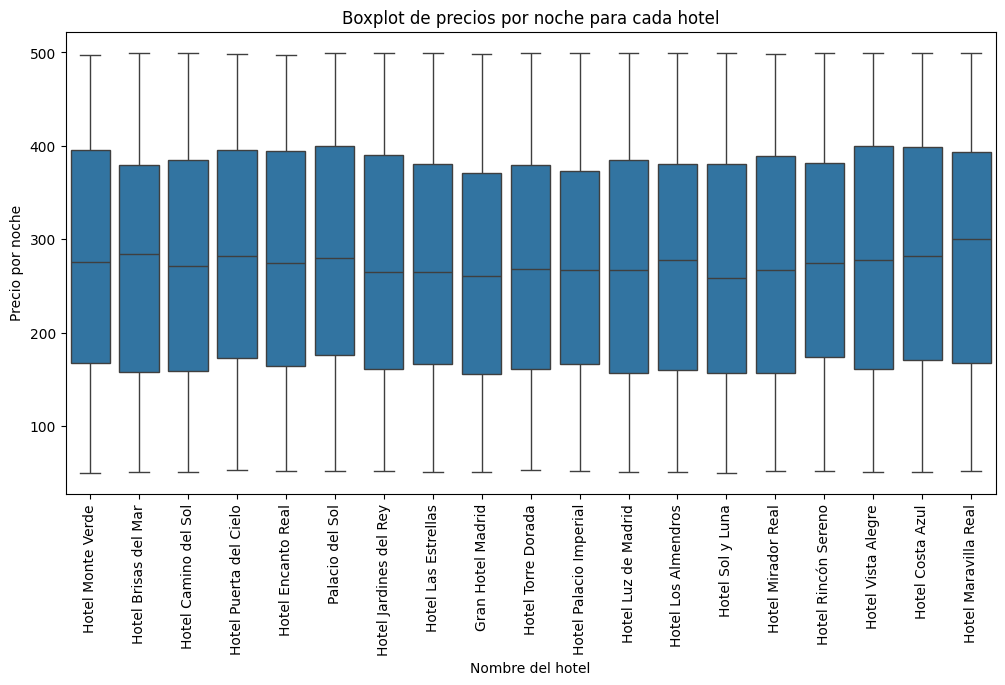

In [33]:
# saca un boxplot para cada hotel sobre la columna precio_noche
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="nombre_hotel", y="precio_noche")

plt.xticks(rotation=90)

plt.title("Boxplot de precios por noche para cada hotel")
plt.xlabel("Nombre del hotel")
plt.ylabel("Precio por noche")

plt.show()

En primer lugar, al analizar las medidas estadísticas, se observa que la media y la mediana del precio por noche en cada uno de los hoteles son muy similares. Esto indica que la distribución de los precios no presenta una gran asimetría ni valores extremos que puedan distorsionar la media. Es decir, la media es una medida estadística fiable para representar el precio típico de una noche en cada hotel, ya que no parece estar influenciada por valores atípicos (outliers).

Para confirmar esta observación inicial, se han analizado los boxplots de los precios por noche. En ellos, se evidencia que las cajas de los diagramas son bastante simétricas y que la mediana, en la mayoría de los casos, se encuentra centrada dentro del rango intercuartil. Además, no se han detectado valores atípicos, ya que no aparecen puntos fuera de los bigotes de los boxplots. Esto refuerza la idea de que la media no está sesgada por outliers y, por lo tanto, puede utilizarse con confianza como una medida representativa del precio típico.

Con base en este análisis, se decide emplear la media como el valor adecuado para imputar los valores nulos en la columna de precios por noche, asegurando así que la información sea lo más representativa y precisa posible.

In [34]:
# funcion que devueleve una lista con los valores de una columna de un dataframe como elementos de la lista
def lista_columnas_df(dataframe, columna):
    lista = []  
    for valor in dataframe[columna]:
        lista.append(valor)
    return lista

In [35]:
# funcion que devuelve un diccionario con las claves como elementos de una lista y los valores como elementos de la otra lista
def creacion_diccionarios(lista1, lista2):
    dicc = dict(zip(lista1, lista2))
    return dicc

In [36]:
# crea el diccionario aplicando las dos funciones lista_columnas_df y creacion_diccionarios 
dicc_medidas = creacion_diccionarios(lista_columnas_df(df_medidas, "nombre_hotel"), lista_columnas_df(df_medidas, "mean"))
dicc_medidas

{'Gran Hotel Madrid': 264.96716504854373,
 'Hotel Brisas del Mar': 275.2259210526316,
 'Hotel Camino del Sol': 269.99844357976656,
 'Hotel Costa Azul': 284.2829629629629,
 'Hotel Encanto Real': 278.24399606299215,
 'Hotel Jardines del Rey': 272.4023353293413,
 'Hotel Las Estrellas': 271.7063529411765,
 'Hotel Los Almendros': 273.7629755178908,
 'Hotel Luz de Madrid': 269.9356074766355,
 'Hotel Maravilla Real': 284.4021186440678,
 'Hotel Mirador Real': 273.2852741020794,
 'Hotel Monte Verde': 276.61238095238093,
 'Hotel Palacio Imperial': 272.2415151515151,
 'Hotel Puerta del Cielo': 280.1512428298279,
 'Hotel Rincón Sereno': 277.31882352941176,
 'Hotel Sol y Luna': 267.93135869565214,
 'Hotel Torre Dorada': 272.7331755424063,
 'Hotel Vista Alegre': 279.802141453831,
 'Palacio del Sol': 282.4921499013806}

In [37]:
# rellena los valores nulos en "precio_noche" de hoteles propios con la media almacenada en dicc_medidas
for hotel in dicc_medidas:
    df.loc[(df["nombre_hotel"] == hotel) & (df["competencia"] == False), "precio_noche"] = df.loc[(df["nombre_hotel"] == hotel) & (df["competencia"] == False), "precio_noche"].fillna(round(dicc_medidas[hotel], 2))

df["precio_noche"].isnull().sum()

np.int64(5172)

Ahora ya como se observa los únicos nulos que quedan en la columna de precio_noche son los de los hoteles de competencia que quedan pendientes de obtener del web scraping.

Una vez hecho el web scraping, como las columnas de fecha_reserva y precio_noche están en la tabla final de reservas, es necesario rellenar los nulos de estas columnas. Los nulos de fecha_reserva se van a rellenar a través de la fecha del scrapeo y los nulos de precio_noche se van a rellenar por los precios escrapeados para cada hotel de la competencia, ya que los de los hoteles propios ya los hemos rellenado con la media. 

AQUI CUANDO TENGA LAS FUNCIONES EN LO DE LA CARPETA SRC Y ESO ES MEJOR QUE EN VEZ DE LEER EL PICKLE ESTE, LLAME A LA FUNCION QUE GENERA EL DICTIO_SCRAP Y LO HAGA TODO CON EL DICTIO_SCRAP DONDE LAS LISTAS YA ESTARÍAN COMO CREADAS DENTRO DEL DICCIONARIO (SERÍA OBTENERLAS POR INDICE) Y EL RESTO DE CREACION DE DICCIONARIOS Y RELLENO DE NULOS SERÍA LO MISMO

In [38]:
# leo el archivo donde contengo la informacion del precio y de la fecha de reserva de los hoteles de la competencia 
df_hoteles_competencia = pd.read_pickle("../data/datos_extraidos/nombre_estrellas_precio.pickle")
df_hoteles_competencia

,nombre_hotel,estrellas,precio_noche,fecha_reserva
0,ibis Styles Madrid Prado,4.7,161.0,2025-02-21
1,ibis budget Madrid Calle 30,4.4,110.0,2025-02-21
2,ibis Madrid Centro las Ventas,4.5,172.0,2025-02-21
3,ibis budget Madrid Centro las Ventas,4.3,119.0,2025-02-21
4,ibis budget Madrid Vallecas,4.3,102.0,2025-02-21
5,ibis Madrid Aeropuerto Barajas,4.4,116.0,2025-02-21
6,ibis Madrid Alcorcon Tresaguas,4.4,90.0,2025-02-21
7,ibis budget Madrid Aeropuerto,4.0,88.0,2025-02-21
8,ibis Madrid Alcobendas,4.4,85.0,2025-02-21
9,ibis budget Madrid Alcorcon Móstoles,4.5,77.0,2025-02-21


Para poder hacer la coincidencia y que rellene los nulos de los hoteles de competencia voy a, en primer lugar, rellenar los nulos de los nombres de hoteles con los nombres de los hoteles de la competencia para hacer la coincidencia por ahí. Para rellenar los nombres en primer lugar voy a asignar de forma aleatoria los id de los que corresponden a los hoteles de la competencia con cada uno de los hoteles, con sus nombres. El primero con el primero, el segundo con el segundo etc.

In [39]:
# saca en lista los id de los hoteles de la competencia 
lista_id_hoteles = df[df["competencia"] == True]["id_hotel"].unique().tolist()
lista_id_hoteles

[113, 194, 131, 114, 103, 181, 128, 186, 135, 117]

In [40]:
# crea un diccionario donde de forma aleatoria las claves van a ser los id y los valores los nombres de los hoteles de la competencia 
dicc_id = creacion_diccionarios(lista_id_hoteles, lista_columnas_df(df_hoteles_competencia, "nombre_hotel"))
dicc_id

{113: 'ibis Styles Madrid Prado',
 194: 'ibis budget Madrid Calle 30',
 131: 'ibis Madrid Centro las Ventas',
 114: 'ibis budget Madrid Centro las Ventas',
 103: 'ibis budget Madrid Vallecas',
 181: 'ibis Madrid Aeropuerto Barajas',
 128: 'ibis Madrid Alcorcon Tresaguas',
 186: 'ibis budget Madrid Aeropuerto',
 135: 'ibis Madrid Alcobendas',
 117: 'ibis budget Madrid Alcorcon Móstoles'}

In [41]:
# funcion que rellena los valores nulos en la columna especificada usando un diccionario para las coincidencias, manteniendo los valores originales si no hay coincidencia en el diccionario
def rellenar_nulos_competencia(dataframe, dicc, columna_rellenar, columna_coincidencia):
    dataframe[columna_rellenar] = dataframe.apply(lambda row: dicc.get(row[columna_coincidencia], row[columna_rellenar]), axis=1)

In [42]:
# actualiza solo los valores de nombre_hotel para los id_hotel que esten en el diccionario
rellenar_nulos_competencia(df, dicc_id, "nombre_hotel", "id_hotel")

In [43]:
# crea un diccionario donde las claves van a ser los nombres de los hoteles y los valores el precio correspondiente a cada uno de ellos 
dicc_precios = creacion_diccionarios(lista_columnas_df(df_hoteles_competencia, "nombre_hotel"), lista_columnas_df(df_hoteles_competencia, "precio_noche"))
dicc_precios

{'ibis Styles Madrid Prado': 161.0,
 'ibis budget Madrid Calle 30': 110.0,
 'ibis Madrid Centro las Ventas': 172.0,
 'ibis budget Madrid Centro las Ventas': 119.0,
 'ibis budget Madrid Vallecas': 102.0,
 'ibis Madrid Aeropuerto Barajas': 116.0,
 'ibis Madrid Alcorcon Tresaguas': 90.0,
 'ibis budget Madrid Aeropuerto': 88.0,
 'ibis Madrid Alcobendas': 85.0,
 'ibis budget Madrid Alcorcon Móstoles': 77.0}

In [44]:
# actualiza solo los valores de precio_noche para los hoteles que esten en el diccionario
rellenar_nulos_competencia(df, dicc_precios, "precio_noche", "nombre_hotel")

In [45]:
# crea un diccionario donde las claves van a ser los nombres de los hoteles y los valores la fecha correspondiente a cada uno de ellos 
dicc_fechas = creacion_diccionarios(lista_columnas_df(df_hoteles_competencia, "nombre_hotel"), lista_columnas_df(df_hoteles_competencia, "fecha_reserva"))
dicc_fechas

{'ibis Styles Madrid Prado': Timestamp('2025-02-21 00:00:00'),
 'ibis budget Madrid Calle 30': Timestamp('2025-02-21 00:00:00'),
 'ibis Madrid Centro las Ventas': Timestamp('2025-02-21 00:00:00'),
 'ibis budget Madrid Centro las Ventas': Timestamp('2025-02-21 00:00:00'),
 'ibis budget Madrid Vallecas': Timestamp('2025-02-21 00:00:00'),
 'ibis Madrid Aeropuerto Barajas': Timestamp('2025-02-21 00:00:00'),
 'ibis Madrid Alcorcon Tresaguas': Timestamp('2025-02-21 00:00:00'),
 'ibis budget Madrid Aeropuerto': Timestamp('2025-02-21 00:00:00'),
 'ibis Madrid Alcobendas': Timestamp('2025-02-21 00:00:00'),
 'ibis budget Madrid Alcorcon Móstoles': Timestamp('2025-02-21 00:00:00')}

In [46]:
# actualiza solo los valores de fecha_reserva para los hoteles que esten en el diccionario
rellenar_nulos_competencia(df, dicc_fechas, "fecha_reserva", "nombre_hotel")

In [47]:
# comprobacion de que se ha hecho correctamente 
df[df["id_hotel"] == 113]

,id_reserva,id_cliente,nombre,apellido,mail,competencia,fecha_reserva,inicio_estancia,final_estancia,id_hotel,precio_noche,nombre_hotel,estrellas,ciudad
0,5256cc90-139b-43d2-8ec5-412495d751cf,1,Feliciana,Cantón,feliciana.cantón@example.com,True,2025-02-21,2025-03-01,2025-03-02,113,161.0,ibis Styles Madrid Prado,NaN,Madrid
47,19b57bd1-9cbf-4c22-a91a-ba4c3850008e,48,Curro,Martín,curro.martín@example.com,True,2025-02-21,2025-03-01,2025-03-02,113,161.0,ibis Styles Madrid Prado,NaN,Madrid
50,d1365d70-a42a-46be-96ca-6e1239b1adf3,51,Melania,Abascal,melania.abascal@example.com,True,2025-02-21,2025-03-01,2025-03-02,113,161.0,ibis Styles Madrid Prado,NaN,Madrid
93,fdd58a9c-4d04-457b-bdf8-e82cc7d60951,94,Tania,Hoz,tania.hoz@example.com,True,2025-02-21,2025-03-01,2025-03-02,113,161.0,ibis Styles Madrid Prado,NaN,Madrid
97,8fc3747d-d6a2-45e4-9cb6-81894e7955bc,98,Mauricio,Gómez,mauricio.gómez@example.com,True,2025-02-21,2025-03-01,2025-03-02,113,161.0,ibis Styles Madrid Prado,NaN,Madrid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14898,6cae6942-2d71-41ae-b22d-ec49ebe02bd7,14805,Fabiola,Pedraza,fabiola.pedraza@example.com,True,2025-02-21,2025-03-01,2025-03-02,113,161.0,ibis Styles Madrid Prado,NaN,Madrid
14915,d1187eda-bf38-42e8-bc6c-5a1468639c26,14821,Máximo,Viana,máximo.viana@example.com,True,2025-02-21,2025-03-01,2025-03-02,113,161.0,ibis Styles Madrid Prado,NaN,Madrid
14935,fa0781f1-54cd-4ba8-857d-5a6e607de1fa,14841,Pánfilo,Ballester,pánfilo.ballester@example.com,True,2025-02-21,2025-03-01,2025-03-02,113,161.0,ibis Styles Madrid Prado,NaN,Madrid
14965,2f3e800a-5133-47e7-9dbb-2e56c7087f13,14871,Gonzalo,Fernandez,gonzalo.fernandez@example.com,True,2025-02-21,2025-03-01,2025-03-02,113,161.0,ibis Styles Madrid Prado,NaN,Madrid


In [48]:
# comprueba que ya no queden nulos en ninguna de estas columnas
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id_reserva       15000 non-null  object        
 1   id_cliente       15000 non-null  object        
 2   nombre           15000 non-null  object        
 3   apellido         15000 non-null  object        
 4   mail             15000 non-null  object        
 5   competencia      15000 non-null  bool          
 6   fecha_reserva    15000 non-null  datetime64[ns]
 7   inicio_estancia  15000 non-null  datetime64[ns]
 8   final_estancia   15000 non-null  datetime64[ns]
 9   id_hotel         15000 non-null  int64         
 10  precio_noche     15000 non-null  float64       
 11  nombre_hotel     15000 non-null  object        
 12  estrellas        9828 non-null   float64       
 13  ciudad           15000 non-null  object        
dtypes: bool(1), datetime64[ns](3), float64(2), 

In [49]:
# importa el dataframe final limpio a un archivo pickle 
df.to_pickle("../data/reservas_hoteles_limpio.pickle")